In [1]:
from framework import StandardScaler
from dql import DQLAgent, DQLTrainer
from ddpg import DDPGAgent, DDPGTrainer, LichtenbergAgent

from PIL import Image
import gym
import numpy as np

def to_gif(matrices, filepath, duration=25):
    frames = []
    for matrix in matrices:
        image = Image.fromarray(matrix)
        frames.append(image)
    frames[0].save(filepath, save_all=True, append_images=frames[1:], duration=duration, loop=0)

## Submarine

In [2]:
from environments.submarine import ContinuousSubmarine
import time

episodes = []
time_taken = []
env = ContinuousSubmarine(delta_t=1, randomize=False) 
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
featurizer = StandardScaler(state_dim, learn=False)
featurizer.mean = np.array([ 7.73739964, 11.54841878,  1.6379028 ,  1.92430292])
featurizer.var = np.array([ 580.12531577, 1460.05771442,   36.57866531,   37.08183991])
# for training comparison stability, ensure that the featurizer scaling is constant

In [ ]:
for _ in range(1):
    # agent = DDPGAgent(state_dim, action_dim, batch_size=32, tau=0.05)
    agent = LichtenbergAgent(state_dim, action_dim, "figure2d.npy", batch_size=32, tau=0.1, n_iter=3, pop=15)

    trainer = DDPGTrainer(env, agent, featurizer, until_convergence=True, convergence_reward=100)
    start = time.perf_counter()
    trainer.train(episodes=10000)
    while not trainer.has_converged(100):
        trainer.train(episodes=100)
    episodes.append(len(trainer.episode_rewards))
    time_taken.append(int(round(time.perf_counter() - start)))
    # print(episodes[-1], time_taken[-1])
    # print(trainer.episode_rewards, trainer.actor_losses, trainer.critic_losses)
    # trainer.plot_losses()
    # trainer.plot_rewards()

## Parking

In [ ]:
import torch
class ParkingFeaturizer(StandardScaler):
    def __init__(self):
        super().__init__(19)
    
    def transform_state(self, state, info=None):
        speed = info['speed'] if info else 0.0
        state = np.concat([state['observation'], state['achieved_goal'], state['desired_goal'], np.array([speed])])
        return torch.tensor(state, dtype=torch.float32).unsqueeze(0)


In [ ]:
import highway_env.envs.parking_env as parking_env

env = parking_env.ParkingEnv({
    "observation": {
        "type": "KinematicsGoal",
        "features": ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
        "scales": [100, 100, 5, 5, 1, 1],
        "normalize": True
    },
    "action": {
        "type": "ContinuousAction"
    },
    "simulation_frequency": 15,
    "policy_frequency": 3,
    "screen_width": 600,
    "screen_height": 300,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": True
})
env.render_mode = 'rgb_array'
featurizer = ParkingFeaturizer()
agent = LichtenbergAgent(19, 2, "figure2d.npy", hidden_layers=3, tau=0.05, batch_size=64, n_iter=3, pop=15)
trainer = DDPGTrainer(env, agent, featurizer)

In [ ]:
trainer.train(episodes=10000)
# trainer.save()

## Inverted Pendulum

In [2]:
import torch
class NoisyFeaturizer(StandardScaler):
    def __init__(self, pct_error=0.0):
        super().__init__(8)
        self.noise = pct_error / 2.0
    
    def transform_state(self, state, info=None):
        state = state[:-3] # ignore the constraint forces

        # add noise before normalization
        noise = np.random.normal(0, self.noise, state.shape)

        # propagate error equally to the derived features
        angles = np.arcsin(state[1:3])
        angles_with_error = np.arcsin(self.var[1:3]) * noise[1:3] + angles
        print(self.var[1:3])
        state[1:3] = np.sin(angles_with_error)
        state[3:5] = np.cos(angles_with_error)
        noise[1:5] = 0.0

        state_with_error = noise * self.var + state
        normalized_state = (state_with_error - self.mean) / np.sqrt(self.var + 1e-8)

        return torch.tensor(normalized_state, dtype=torch.float32).unsqueeze(0)

In [ ]:
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = DDPGAgent(state_dim, action_dim, hidden_layers=2, tau=0.01, batch_size=256)

featurizer = NoisyFeaturizer()
# experimentally approximated mean and standard deviation of state vector
featurizer.mean = np.array([-0.0537724 , # position of the cart along the linear surface (m)
                             0.00854607, # sine of the angle between the cart and the first pole
                            -0.0020691 , # sine of the angle between the two poles
                             0.97681748, # cosine of the angle between the cart and the first pole
                             0.97418304, # cosine of the angle between the two poles
                             0.00404627, # velocity of the cart (m/s)
                             0.03138314, # angular velocity of the angle between the cart and the first pole (rad/s)
                            -0.03641539, # angular velocity of the angle between the two poles (rad/s)
                            -0.0363062 , # constraint force - 1 (N)
                             0.        , # constraint force - 2 (N)
                             0.          # constraint force - 3 (N)
                             ])[:-3]
featurizer.var = np.array([4.08496608e-02, 9.94629836e-02, 1.39189335e-01, 7.58616097e-03,
                           1.25376890e-02, 6.61337497e+00, 2.03311682e+01, 1.82406234e+01,
                           3.15706362e-02, 0.00000000e+00, 0.00000000e+00])[:-3]

In [7]:
featurizer.var

array([4.08496608e-02, 9.94629836e-02, 1.39189335e-01, 7.58616097e-03,
       1.25376890e-02, 6.61337497e+00, 2.03311682e+01, 1.82406234e+01,
       3.15706362e-02, 0.00000000e+00, 0.00000000e+00])

In [6]:
# featurizer = StandardScaler(input_dim=state_dim)
trainer = DDPGTrainer(env, agent, featurizer)
trainer.train()

 64%|██████▍   | 638/1000 [00:28<00:16, 22.31it/s]


KeyboardInterrupt: 

In [22]:
avg_rewards = []
std_rewards = []
error_range = np.linspace(0.0, 0.5, 41) # defines two standard deviations of the gaussian (95% confidence of being within error range)
n = 100 # episodes per test
agent = DDPGAgent(state_dim-3, action_dim, hidden_dim=64, hidden_layers=2, tau=0.05, batch_size=64)
for pct_error in error_range:
    featurizer.noise = pct_error / 2.0
    trainer = DDPGTrainer(env, agent, featurizer, until_convergence=True, convergence_reward=8000)
    trainer.train(episodes=10000)
    rewards = np.array([trainer.run_episode(False)['reward'] for _ in range(n)])
    avg_rewards.append(np.mean(rewards))
    std_rewards.append(np.std(rewards)/np.sqrt(n))

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_165797/3902402593.py:15: RuntimeWarning: invalid value encountered in arcsin
  angles_with_error = np.arcsin(self.var[1:3]) * noise[1:3] + angles
  0%|          | 9/10000 [00:00<01:59, 83.88it/s]

[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 

  0%|          | 26/10000 [00:00<02:32, 65.55it/s]

[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412

  0%|          | 40/10000 [00:00<02:38, 63.04it/s]

[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 

  0%|          | 47/10000 [00:00<02:38, 62.67it/s]

[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 

  1%|          | 61/10000 [00:00<02:38, 62.73it/s]

[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 

  1%|          | 75/10000 [00:01<02:44, 60.44it/s]

[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 

  1%|          | 89/10000 [00:01<02:44, 60.34it/s]

[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412

  1%|          | 96/10000 [00:01<02:44, 60.21it/s]

[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412

  1%|          | 109/10000 [00:01<02:51, 57.62it/s]

[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 

  1%|          | 123/10000 [00:01<02:44, 60.15it/s]

[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412

  1%|▏         | 137/10000 [00:02<02:45, 59.52it/s]

[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 

  1%|▏         | 149/10000 [00:02<02:45, 59.43it/s]

[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 

  2%|▏         | 163/10000 [00:02<02:46, 58.97it/s]

[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412

  2%|▏         | 170/10000 [00:02<02:43, 60.23it/s]

[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412

  2%|▏         | 184/10000 [00:03<02:40, 61.26it/s]

[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 

  2%|▏         | 198/10000 [00:03<02:38, 61.86it/s]

[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 

  2%|▏         | 203/10000 [00:03<02:42, 60.33it/s]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 1.99413297]

[1.66169412 1.99413297]
[1.66169412 1.99413297]
[1.66169412 

KeyboardInterrupt: 

In [91]:
error_range

array([0.    , 0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875,
       0.1   , 0.1125, 0.125 , 0.1375, 0.15  , 0.1625, 0.175 , 0.1875,
       0.2   , 0.2125, 0.225 , 0.2375, 0.25  , 0.2625, 0.275 , 0.2875,
       0.3   , 0.3125, 0.325 , 0.3375, 0.35  , 0.3625, 0.375 , 0.3875,
       0.4   , 0.4125, 0.425 , 0.4375, 0.45  , 0.4625, 0.475 , 0.4875,
       0.5   ])

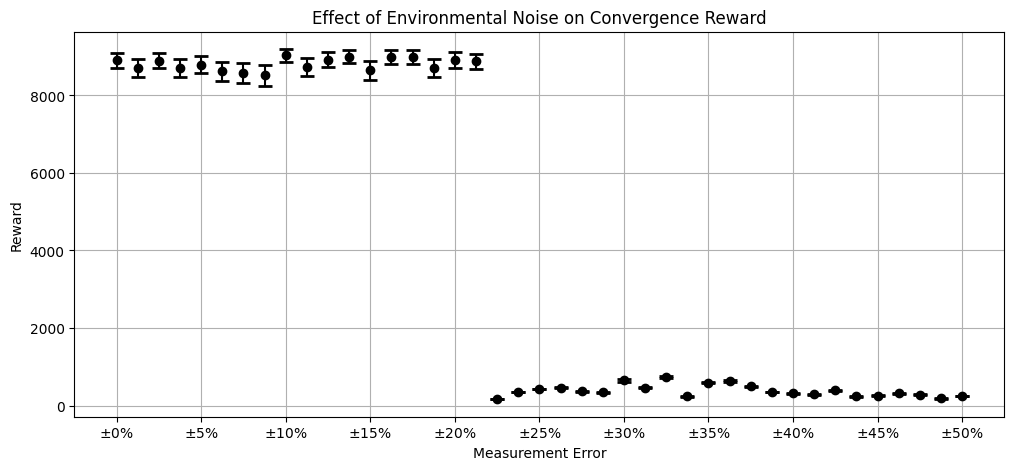

In [88]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 5))
ax.errorbar(error_range, avg_rewards, yerr=std_rewards, fmt="o", capsize=5, capthick=2, color="black")
# ax.plot(n, r_mean, color="black", alpha=0.5)

ax.set_xlabel("Measurement Error")
ax.set_ylabel("Reward")
ax.set_title("Effect of Environmental Noise on Convergence Reward")
# change the font and make the x axis have more ticks and percent sign
X = np.linspace(0.0, 0.5, 11)
ax.set_xticks(X)
ax.set_xticklabels(["$\pm${:.0f}%".format(x*100) for x in X])

ax.grid()
plt.show()

## Ball and Beam Problem

In [ ]:
import ballbeam_gym.envs
import warnings
warnings.filterwarnings('ignore')

env = ballbeam_gym.envs.BallBeamSetpointEnv(timestep=0.02, setpoint=-0.8, beam_length=2.0, max_angle=0.5, max_timesteps=500, action_mode='discrete')
env.action_space = np.arange(3)
state_dim = env.observation_space.shape[0]

featurizer = StandardScaler(state_dim)
agent = DQLAgent(state_dim, env.action_space.shape[0], batch_size=128, epsilon_decay=0.9995)

In [ ]:
trainer = DQLTrainer(env, agent, featurizer)
trainer.train(episodes=1000)
trainer.plot_losses()

In [ ]:
info = trainer.run_episode()
to_gif(info['rgb_arrays'], 'ball_and_beam.gif', duration=25)

## Panda Reach

In [3]:
import torch
class PandaFeaturizer(StandardScaler):
    def __init__(self):
        super().__init__(12)
    
    def transform_state(self, state, info=None):
        state = np.concatenate([state['achieved_goal'], state['desired_goal'], state['observation']])
        return torch.tensor(state, dtype=torch.float32).unsqueeze(0)

In [ ]:
import gymnasium 
import panda_gym
env = gymnasium.make('PandaReach-v3', render_mode="rgb_array")
featurizer = PandaFeaturizer()
agent = DDPGAgent(12, env.action_space.shape[0])
trainer = DDPGTrainer(env, agent, featurizer)
